### Train GP emulator for PFT mean LAI max
##### Linnia Hawkins 9-11-2023

In [12]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xarray as xr
#import glob
import matplotlib
import matplotlib.pyplot as plt
#import cftime
#import dask
#import os
import gpflow
#import tensorflow as tf
from esem.utils import get_random_params

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") 
from ppe_analysis.analysis import *
from emulation_pyfunctions import *
from pyfunctions import *

### Load LHC CLM-PPE (PFT mean annual max LAI)

In [3]:
# set PFT index
p = 1 # 1=needleleaf evergreen tree

In [4]:
#Load PPE
LHC_pmean=xr.open_dataset('/glade/u/home/linnia/clm5ppe/pyth/exp2_PFT/processed_data/LHC_pmean(TLAImax).nc')
NL_LAI_PPE = LHC_pmean['TLAI_pftavg_annMax_2003-2014'].sel(pft=p)

In [5]:
# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
params = df.drop(columns='member')
nparams = len(params.columns)

### Load Observational Target data

In [6]:
#calculate SP LAI, by pft
dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
sg=xr.open_dataset('../clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
la=sg.landfrac*sg.area

lai_sp=amax(dsp.TLAI).sel(year=2000)
w=dsp.pfts1d_wtgcell
laig=pftgrid(lai_sp,dsp)
wg=pftgrid(w,dsp)
cf=1/(wg*la).sum(dim=['lat','lon'])
laisp=cf*(laig*wg*la).sum(dim=['lat','lon']).sel(pft=range(0,16)).compute()

In [7]:
# Observational target
NL_LAI_obs = laisp[p]

### Train PFT emulators

In [9]:
# Define kernels
kernel_linear = gpflow.kernels.Linear(active_dims=range(nparams),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(nparams), variance=1, lengthscales = np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(nparams), lengthscales=np.tile(1,nparams))

# select the kernal to use
kernel = kernel_linear + kernel_matern32 + kernel_RBF

2023-09-11 16:42:30.546913: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-11 16:42:30.546967: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (casper10): /proc/driver/nvidia/version does not exist
2023-09-11 16:42:30.552195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


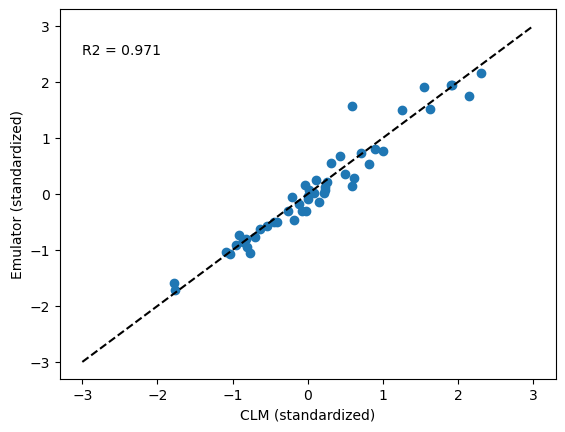

In [10]:
ntest = 50
data = NL_LAI_PPE[1:]

Y = standardize(data)

# split training and testing data
X_test, X_train = params[:ntest], params[ntest:]
y_test, y_train = Y[:ntest], Y[ntest:]

# define emulator model and train
emulator = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel, mean_function=None)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(emulator.training_loss, emulator.trainable_variables, options=dict(maxiter=100))

y_pred, y_var = emulator.predict_f(X_test.values)

# plot validation
ax = plt.subplot(1,1,1)
plot_validation(y_test, np.array(y_pred), ax)

### Sample and Predict

In [13]:
### Take a random sample from parameter space and use emulator to estimate LAI
#randomly sample parameters
n_samp = 1000
sample = get_random_params(nparams, n_samp)

In [15]:
y_pred, y_pred_var = emulator.predict_f(sample) 

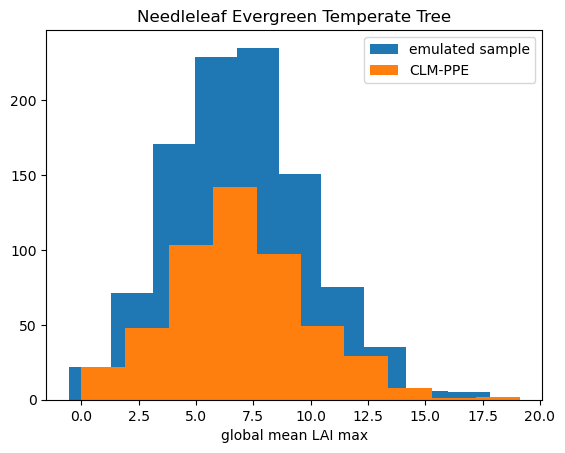

In [21]:
# unstandardize and plot
NL_LAI_pred = unstandardize(np.array(y_pred).reshape(1,-1),NL_LAI_PPE)
plt.hist(NL_LAI_pred.flatten(),label='emulated sample')
plt.hist(NL_LAI_PPE,label='CLM-PPE')
plt.xlabel('global mean LAI max')
plt.title('Needleleaf Evergreen Temperate Tree')
plt.legend()